In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy import stats
import cv2
import pywt
from scipy.ndimage import uniform_filter
from skimage import io, util

# Load a sample images
flower = cv2.cvtColor(cv2.imread('images/flower.jpg'), cv2.COLOR_BGR2RGB)
veg = cv2.cvtColor(cv2.imread('images/veg.png'), cv2.COLOR_BGR2RGB)
girl= cv2.cvtColor(cv2.imread('images/girl2.png'), cv2.COLOR_BGR2RGB)

# Convert images to Grayscale
flower_img = cv2.cvtColor(flower, cv2.COLOR_RGB2GRAY)
veg_img = cv2.cvtColor(veg, cv2.COLOR_RGB2GRAY)
girl_img = cv2.cvtColor(girl, cv2.COLOR_RGB2GRAY)
   

def show_images(images, titles, images_per_row=3, cmap='gray'):
    """Display a list of images using matplotlib."""
    num_images = len(images)
    num_rows = np.ceil(num_images / images_per_row).astype(int)
    
    # Set the figure size to closely match the manual plot example (15, 5)
    figure_width = 15  # Fixed width
    figure_height = 5 * num_rows  # Adjusted by the number of rows

    plt.figure(figsize=(figure_width, figure_height))

    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(num_rows, images_per_row, i + 1)
        # If images have different ranges, you might want to set vmin and vmax
        # to the min and max of each image respectively:
        # vmin, vmax = image.min(), image.max()
        # Or, for normalized images, you can omit vmin and vmax to use the default behavior
        plt.imshow(image, cmap=cmap)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Understanding Digital Image Processing

## Image Denoising
### 6.1 Introduction
In the digital age, images and videos are an integral part of our daily communication and media consumption. High-quality visual content is crucial for everything from personal photo sharing to professional publications, making the clarity and visual integrity of images paramount. However, digital images are often susceptible to various forms of noise, which can occur during acquisition, such as when captured by a camera, or throughout processing and transmission. Noise manifests as random visual artifacts that detract from the clarity of the image, often resulting in a grainy appearance that can obscure details and reduce overall quality.

Image denoising is a critical preprocessing step in digital image processing aimed at mitigating the effects of noise. The goal is to reconstruct the original image by estimating it from its noisy observation, thereby preserving the essential features such as edges, textures, and patterns that are vital for interpretation by human viewers or subsequent automated analysis. Effective denoising balances the trade-off between noise removal and the preservation of important image details.

As illustrated a pristine input image $ f(x, y) $ can be corrupted by noise $ n(x, y) $ to give a degraded noisy image $ g(x, y) $. The denoising task seeks to produce a denoised image $ \hat{f}(x, y) $ that is a close representation of the original $ f(x, y) $. The fidelity of the denoised image to the original is largely dependent on the knowledge of the noise characteristics $ n(x, y) $. Understanding these characteristics enables more effective noise suppression techniques.

The subsequent sections will delve into common noise models that affect digital images, outline the attributes of noise, and discuss various established techniques for noise reduction. Through these discussions, we aim to provide insights into the challenges and methodologies of image denoising, setting the stage for deeper exploration into this essential aspect of image processing.

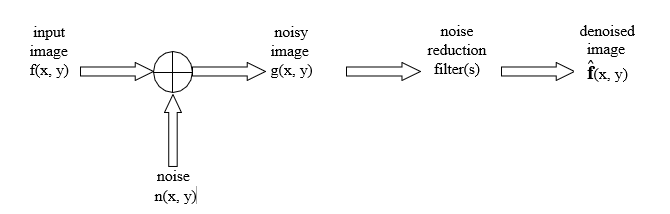

# Understanding Digital Image Processing

## Image Denoising

### 6.2 Image Noise Types

In the realm of digital imaging, noise represents unwanted fluctuations in pixel intensity or color that deviate from the true values in an original scene. It can arise during image capture, due to sensor limitations or environmental conditions, as well as during transmission or storage, often due to electronic interference or data compression errors.

#### 6.2.1 Spatially Independent Noise
Spatially independent noise, also known as uncorrelated noise, is noise that does not depend on the image content or spatial location within the image. It is characterized by its statistical properties, which are uniform throughout the image. Common types of spatially independent noise include:


1. **Gaussian Noise**: This is the most prevalent type of noise in digital imaging, often due to electronic circuitry or sensor noise. The PDF of Gaussian noise follows a normal distribution, characterized by its bell shape. The mean $ \mu $ and variance $ \sigma^2 $ are parameters of this distribution, where $ \mu $ represents the average or center of the distribution, and $ \sigma^2 $ represents the spread or "width" of the bell curve.

2. **Salt and Pepper (Impulse) Noise**: This noise appears as sporadic white and black pixels, or "salt and pepper," in an image. The noise is not normally distributed; it takes specific values $ a $ and $ b $ (usually the extremes of the pixel value range) with probabilities $ P_a $ and $ P_b $, respectively. The mean and variance are calculated based on these values and their probabilities.

3. **Rayleigh Noise**: This type of noise has a PDF that starts at a minimum value $ a $ and increases until it tails off. It's often encountered in radar and sonar imaging. The mean and variance are determined by the parameter $ b $ of the Rayleigh distribution.

4. **Gamma Noise**: This is characterized by the gamma distribution and is parameterized by $ a $ and $ b $. It can occur in imaging where the noise level is related to the intensity of the signal, such as in photon counting. The mean and variance are dependent on both parameters.

5. **Exponential Noise**: This noise has an exponential distribution, commonly occurring in processes where events happen continuously and independently at a constant average rate. The PDF is zero for negative values and exponential for non-negative values. The mean and variance are both inversely proportional to the parameter $ a $.

6. **Uniform Noise**: As the name suggests, this type of noise has a uniform distribution within a specific range from $ a $ to $ b $. It represents random fluctuations within a fixed range and is less common in natural images. The mean is the midpoint of $ a $ and $ b $, and the variance is a function of the range.

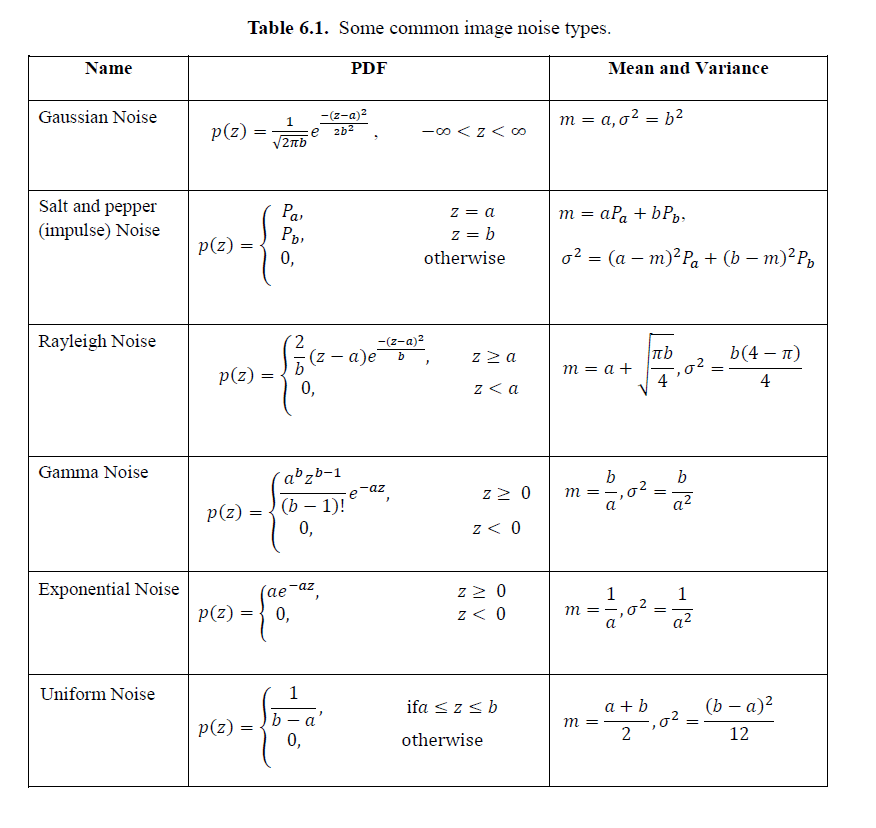

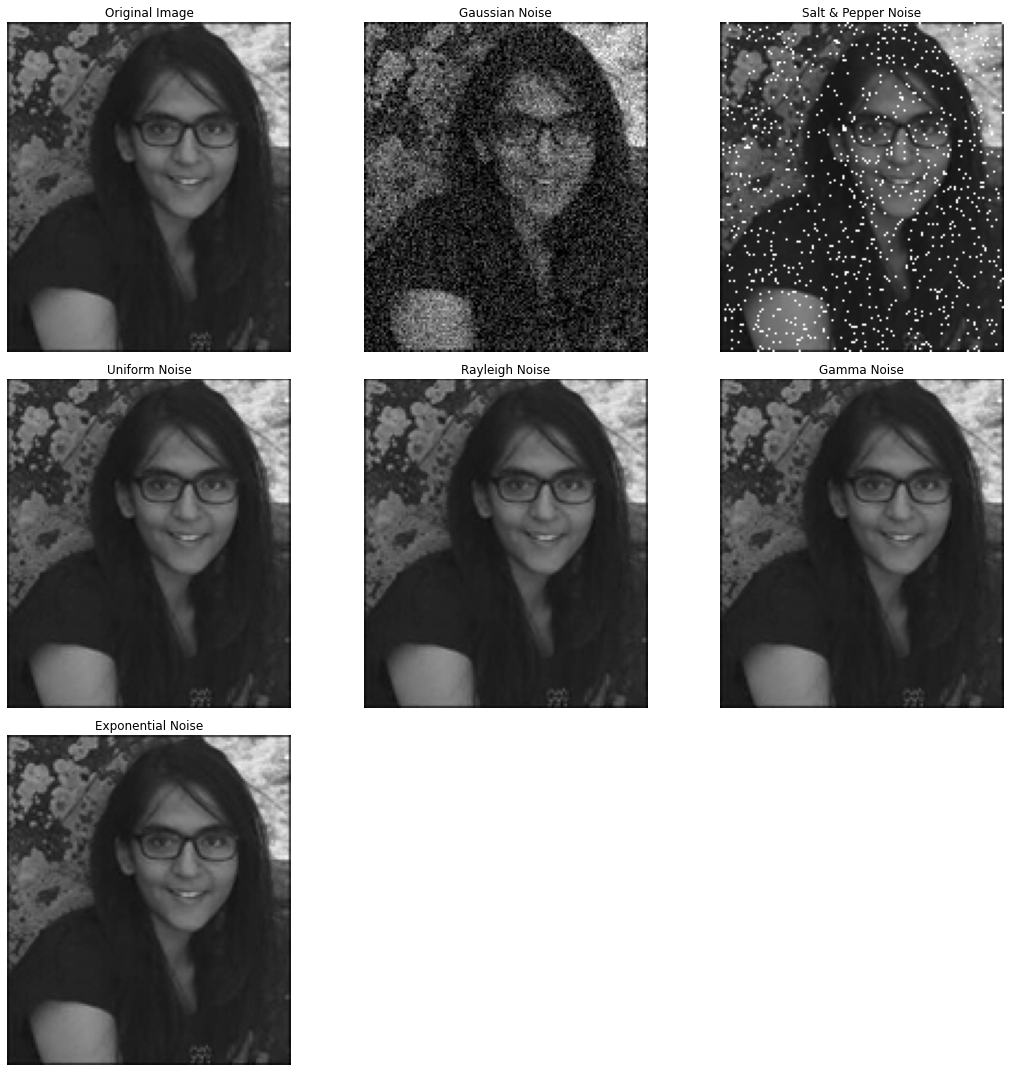

In [2]:
from skimage.util import random_noise

# Add Gaussian noise
gaussian_noisy_image = random_noise(girl_img, mode='gaussian', mean=0, var=0.01)

# Add Salt and pepper noise
sp_noisy_image = random_noise(girl_img, mode='salt', amount=0.05)

# Add Rayleigh noise
# For Rayleigh noise, we can use `np.random.rayleigh` and then combine with the image
rayleigh_noise = np.random.rayleigh(scale=0.05, size=girl_img.shape)
rayleigh_noisy_image = girl_img + rayleigh_noise

# Add Gamma noise
# There is no direct function in skimage, so we'll use numpy
gamma_noise = np.random.gamma(shape=1.0, scale=0.05, size=girl_img.shape)
gamma_noisy_image = girl_img + gamma_noise

# Add Exponential noise
exp_noise = np.random.exponential(scale=0.05, size=girl_img.shape)
exp_noisy_image = girl_img + exp_noise

# Add Uniform noise
uniform_noise = np.random.uniform(low=-0.05, high=0.05, size=girl_img.shape)
uniform_noisy_image = girl_img + uniform_noise

# Display the original and noisy images
show_images([girl_img, gaussian_noisy_image, sp_noisy_image, uniform_noisy_image, rayleigh_noisy_image, gamma_noisy_image, exp_noisy_image], 
            ['Original Image', 'Gaussian Noise', 'Salt & Pepper Noise', 'Uniform Noise', 'Rayleigh Noise', 'Gamma Noise', 'Exponential Noise' ], images_per_row=3)

#### 6.2.2 Spatially Dependent Noise
Spatially dependent noise, as the name implies, is not uniform across the image but varies depending on the pixel's location and often the pixel's value. Unlike spatially independent noise, which is random and equally distributed, spatially dependent noise can introduce patterns or structures into the image, which may mimic or obscure actual features within the image.

One of the most common types of spatially dependent noise is periodic noise. This noise has a regular pattern and is often introduced into an image by interference with the sensor's electronic components or external electromagnetic fields. For example, power lines or faulty components within a camera can introduce wave-like or repetitive artifacts into captured images.

Periodic noise can often be identified in the frequency domain, where it appears as distinct spikes outside the origin. These spikes represent the frequencies of the noise patterns, and because of their regularity, they can sometimes be reduced or removed by frequency domain filters like notch filters.

In Python, we don't have a built-in function like MATLAB's `imnoise` to directly introduce periodic noise. However, we can simulate such noise by adding a sinusoidal pattern to an image. Here's an example of how to do this:

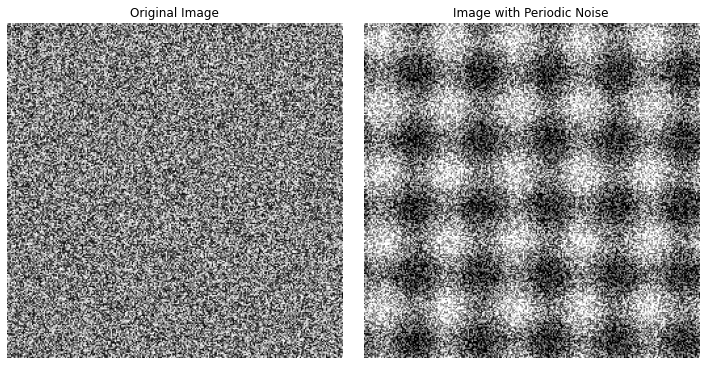

In [3]:
def add_periodic_noise(image, frequency, amplitude):
    """
    Add sinusoidal periodic noise to an image.
    
    :param image: Input image as a numpy array.
    :param frequency: Frequency of the sinusoidal noise.
    :param amplitude: Amplitude of the sinusoidal noise.
    :return: Image with periodic noise added.
    """
    rows, cols = image.shape
    noise = np.sin(2 * np.pi * frequency * (np.arange(rows)[:, None] / rows))
    noise = noise + np.sin(2 * np.pi * frequency * (np.arange(cols) / cols))
    noisy_image = image + amplitude * noise
    return np.clip(noisy_image, 0, 1)

# Load an example image and convert to float
image = np.random.rand(256, 256)  # Replace this with your actual grayscale image

# Parameters for the periodic noise
frequency = 5  # Frequency of the sinusoidal noise
amplitude = 0.2  # Amplitude of the sinusoidal noise

# Add periodic noise to the image
noisy_image = add_periodic_noise(image, frequency, amplitude)

# Display images

show_images([image, noisy_image], ["Original Image", "Image with Periodic Noise"])


### 6.3 Image Denoising
Image denoising is the process of reducing noise from an image. Noise can manifest as random variations in the image's brightness or color and can arise during image acquisition due to sensor imperfections, or during transmission due to compression or transmission errors. Effective denoising seeks to reduce noise while preserving important image features such as edges and fine details. Based on the domain, image denoising methods are classified as spatial domain methods and transform domain methods.

#### 6.3.1 Spatial Domain Methods
Spatial domain methods apply filters directly to the pixels of an image. These methods can be categorized into linear and nonlinear approaches:

- **Linear Spatial Domain Filters**: These include methods like box filtering (mean filtering) which replace each pixel value with the average of its neighborhood. Such techniques are fast but often result in a loss of detail and sharpness in the image.
  
- **Nonlinear Spatial Domain Filters**: These filters, such as the median filter, preserve edges better than linear filters. They work by replacing each pixel value with a function of its neighborhood, often the median, which is less sensitive to outliers.

#### 6.3.2 Transform Domain Methods
Transform domain methods first convert the image into a frequency or another domain where noise characteristics can be distinguished from the signal. After denoising in this domain, the image is transformed back to the spatial domain. This category includes:

- **Data Adaptive Transform**: These transforms adapt based on the image content to provide efficient denoising, such as wavelet transforms which are sensitive to image edges.
  
- **Non-Data Adaptive Transform**: These use fixed basis functions for transformation, like the Fourier transform, and can be less effective at edge preservation.

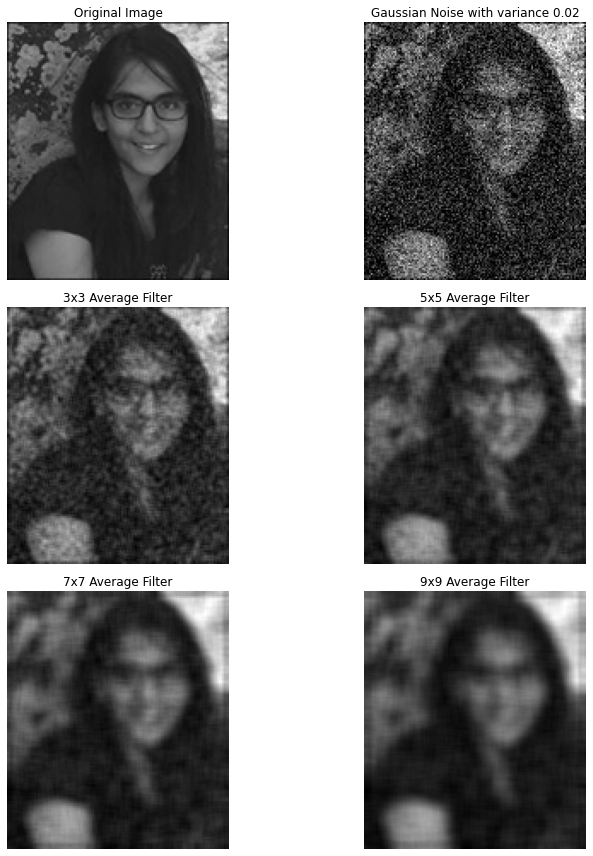

In [4]:
# Add Gaussian noise to the image
noisy_img = util.random_noise(girl_img, mode='gaussian', var=0.02)

# Apply average filters of various sizes
b = uniform_filter(noisy_img, size=3)
c = uniform_filter(noisy_img, size=5)
d = uniform_filter(noisy_img, size=7)
e = uniform_filter(noisy_img, size=9)

# Display the original and denoised images
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs[0, 0].imshow(girl_img, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 1].imshow(noisy_img, cmap='gray')
axs[0, 1].set_title('Gaussian Noise with variance 0.02')
axs[1, 0].imshow(b, cmap='gray')
axs[1, 0].set_title('3x3 Average Filter')
axs[1, 1].imshow(c, cmap='gray')
axs[1, 1].set_title('5x5 Average Filter')
axs[2, 0].imshow(d, cmap='gray')
axs[2, 0].set_title('7x7 Average Filter')
axs[2, 1].imshow(e, cmap='gray')
axs[2, 1].set_title('9x9 Average Filter')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


### 6.4 Performance Evaluation of Denoising Techniques

When it comes to assessing the efficacy of image denoising methods, objective evaluation metrics are indispensable. They allow us to quantitatively measure the extent to which denoising algorithms fulfill two crucial objectives: noise reduction and detail preservation.

#### 6.4.1 Mean Square Error (MSE)

- **Definition**: MSE is a straightforward, easy-to-understand metric that captures the average of the squares of the errors, i.e., the differences between corresponding pixel values in the original and the denoised image. It's a measure of the energy of the error introduced by the denoising process.
  
- **Formula**: 
    $$ \text{MSE} = \frac{1}{M \times N} \sum_{x=1}^{M} \sum_{y=1}^{N} \left(f(x,y) - \hat{f}(x,y)\right)^2 $$
  
    Where:
    - \( f(x,y) \) represents the pixel intensity of the original image at location (x, y).
    - \( \hat{f}(x,y) \) denotes the pixel intensity of the denoised image at the same location.
    - \( M \) and \( N \) are the width and height of the images, respectively.

- **Interpretation**: Lower MSE values signify a smaller cumulative squared error across the image, suggesting a better performance of the denoising algorithm.

In [5]:
def mse(image_a, image_b):
    # Ensure the images are the same size.
    assert image_a.shape == image_b.shape, "Images must have the same dimensions."
    
    # Compute MSE.
    err = np.sum((image_a.astype("float") - image_b.astype("float")) ** 2)
    err /= float(image_a.shape[0] * image_a.shape[1])
    
    return err

#### 6.4.2 Peak Signal-to-Noise Ratio (PSNR)

- **Definition**: PSNR is a log-scale measure of the peak error, providing insight into the relationship between the maximum possible pixel value of an image and the power of the corrupting noise. It's commonly used in image processing to benchmark image restoration quality.
  
- **Formula**: 
    $$ \text{PSNR} = 10 \log_{10} \left( \frac{255^2}{\text{MSE}} \right) $$
  
    Note that the value 255 pertains to the maximum pixel value for an 8-bit image.

- **Interpretation**: Higher PSNR typically implies a better quality of the denoised image, as it indicates that the magnitude of noise is small relative to the signal strength.

In [6]:
def psnr(image_a, image_b):
    # Calculate MSE.
    mse_value = mse(image_a, image_b)
    
    # Calculate PSNR.
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse_value))
    
    return psnr_value

#### 6.4.3 Structural Similarity Index (SSIM)

- **Definition**: SSIM is an advanced metric that evaluates the perceptual quality of images by considering changes in texture, brightness, and contrast. It goes beyond pixel-wise comparisons to assess structural integrity and perceptual resemblance.
  
- **Formula**: 
    $$ \text{SSIM}(X, Y) = \frac{(2\mu_X \mu_Y + C_1)(2\sigma_{XY} + C_2)}{(\mu_X^2 + \mu_Y^2 + C_1)(\sigma_X^2 + \sigma_Y^2 + C_2)} $$
  
    Where:
    - \( \mu_X, \mu_Y \) are the mean intensities of images X and Y.
    - \( \sigma_X^2, \sigma_Y^2 \) are the variances.
    - \( \sigma_{XY} \) is the covariance.
    - \( C_1, C_2 \) are constants that stabilize the division with a weak denominator, often set to avoid division by zero.

- **Interpretation**: A higher SSIM value indicates greater similarity between the two images, suggesting that the denoising process has preserved structural information effectively.

In [7]:
from skimage.metrics import structural_similarity as compare_ssim

def ssim(image_a, image_b):
    ssim_value, _ = compare_ssim(image_a, image_b, full=True)
    return ssim_value

#### 6.4.4 Pratt's Figure of Merit (FOM)

- **Definition**: FOM is a specialized metric that quantifies the accuracy of edge detection in denoised images, assessing the extent to which the denoising process has preserved or blurred the important edge details.
  
- **Formula**:
    $$ \text{FOM} = \frac{1}{\text{max}(N_{ide}, N_{det})} \sum_{i=1}^{N_{det}} \frac{1}{1 + \alpha d_i^2} $$
  
    Where:
    - \( N_{ide} \) is the number of edge pixels in the original image.
    - \( N_{det} \) is the number of edge pixels detected in the denoised image.
    - \( d_i \) is the Euclidean distance between detected and true edge pixels.
    - \( \alpha \) is a constant that penalizes the displacement of detected edges from their true positions.

- **Interpretation**: A FOM score close to 1 indicates excellent edge preservation, while lower values suggest that edge details may have

In [8]:
def pratt_fom(detected_edges, ideal_edges, alpha=1/9):
    N_det = len(detected_edges)
    N_ide = len(ideal_edges)
    
    # Initialization of the FOM sum.
    fom_sum = 0
    
    for d_edge in detected_edges:
        # Find the nearest ideal edge for each detected edge.
        distances = np.sqrt((ideal_edges - d_edge) ** 2)
        d_i = np.min(distances) # Closest distance.
        
        # Pratt's FOM formula component for the detected edge.
        fom_sum += 1 / (1 + alpha * (d_i ** 2))
    
    # Pratt's FOM final calculation.
    fom_value = fom_sum / max(N_ide, N_det)
    return fom_value